# Solving the quantum many-body problem with NQS
## Su–Schrieffer–Heeger model

In [25]:
# Front Matters
import numpy as np  
import matplotlib.pyplot as plt

N = 4

v = 1  # intracell hopping 
w = 1 # intercell hopping

## Exact ground state energy 

$H_{ij}=<m,A|H|m,A>$

In [26]:
diag_array = [v if i % 2 == 0 else w for i in range(2 * N-1)]

# Hamiltonian matrix
Hamiltonian = np.diag(diag_array, k=1)+np.diag(diag_array, k=-1)

# periodic boundary condition
boundary = np.zeros_like(Hamiltonian)
boundary[0, 2*N-1] = w
boundary[2*N-1, 0] = w

Hamiltonian += boundary 
print(Hamiltonian)

# Eigenvalues 
eigenvalues, eigenvectors = np.linalg.eig(Hamiltonian)
print(np.sort(eigenvalues))

[[0 1 0 0 0 0 0 1]
 [1 0 1 0 0 0 0 0]
 [0 1 0 1 0 0 0 0]
 [0 0 1 0 1 0 0 0]
 [0 0 0 1 0 1 0 0]
 [0 0 0 0 1 0 1 0]
 [0 0 0 0 0 1 0 1]
 [1 0 0 0 0 0 1 0]]
[-2.00000000e+00 -1.41421356e+00 -1.41421356e+00 -9.75400566e-17
  1.28959293e-16  1.41421356e+00  1.41421356e+00  2.00000000e+00]


In [31]:
# theroetical result
k=0
result = -np.sqrt(v**2+w**2+2*v*w*np.cos(k))
print(result)

-2.0


In [30]:
# Test transation 
# Initial state
vector = [0, 0, 1, 0,1,0,1,1]

# 计算内积
result = np.dot(Hamiltonian, vector)

# 打印结果
print(result)
print(vector)

[1 1 0 2 0 2 1 1]
[0, 0, 1, 0, 1, 0, 1, 1]


## NQS ground state

In [10]:
# Initialize NQS

# Generate hiden nodes.
alpha = 2 
M = alpha * 2*N  

# Initialize the weights and biases
def random_complex(size): 
    a = (np.random.random(size) - .5) * 10e-2  
    b = (np.random.random(size) - .5) * 10e-2  # random number -0.005~0.005
    return a + 1j*b  
a = random_complex(N)  
b = random_complex(M)  
W = random_complex((N,M)) 

Variational expression for the wave function:

$\begin{aligned} \Psi_N(\boldsymbol{S},\boldsymbol{W} ) & = \langle S|\psi\rangle=\sum_{h_j \in\{-1,1\}} \exp (\boldsymbol{a}^T \boldsymbol{S}+\boldsymbol{b}^T \boldsymbol{h}+\boldsymbol{S}^T \boldsymbol{W} \boldsymbol{h}) \\ & =\exp (\boldsymbol{a}^T \boldsymbol{S}) \prod_j^{M} 2 \cosh (\theta_j)\end{aligned}$

where the effective angle $\theta_j(\mathcal{S})=b_j+\sum_i  W_{i j}\sigma_i$.

In [2]:
# define wave function
def theta(state):  
    return b + W.T @ state  

def Psi_M(state):  
    return np.exp(a @ state) * np.prod(2*np.cosh(theta(state)))  

Hamiltonian of Su–Schrieffer–Heeger model:
$$H=v \sum_{m=1}^N(|m, B\rangle\langle m, A|+ h.c. )+w \sum_{m=1}^{N-1}(|m+1, A\rangle\langle m, B|+ h.c. )$$
Calculating the local energy for a state $\mathcal{S}$,

$$E_\text{loc}=\frac{\langle\mathcal{S}|H|\Psi_M\rangle}{\langle\mathcal{S}|\Psi_M\rangle}=\frac{\sum_{S'}\Psi_M(S')\langle\mathcal{S}|H|S'\rangle}{\Psi_M(\mathcal{S})}$$


In [3]:
# define local energy
def E_local(state):
    # intracell hopping 
    state=np.array(state)

    E_intra = 0 
    for i in range(N): 
        if i == N-1:  
            E_intra+=(state[i]*state[0])
        else:
            E_intra+=(state[i]*state[i+1])
    E_intra = -1*E_intra

    E_inter= 0
    # intercell hopping
    for i in range(N):  
        state[i] *= -1  
        E_inter += -Psi_M(state)
        state[i] *= -1  # 恢复原值
    E_inter = -E_inter/Psi_M(state)  # 除以波函数

    E_total= E_intra + E_inter 
    return E_total/N  # 返回E除以N的值作为局部能量

In [4]:
# Import the product function to generate all possible basis states
from itertools import product

# Generate all possible basis states
basis = list(product([1,-1],repeat=N))


# Calculate the local energy for each basis state
E = [E_local(basis[i]) for i in range(2**N)]

# Calculate the average local energy
avg_E_local = np.mean(E)
print("The average local energy is: ", avg_E_local)

The average local energy is:  (9.996661252878951-0.016110014623478774j)


Markov chain sampling
$$S_0 \xrightarrow[and \ judge]{flip \ a \ spin} S_1 \rightarrow S_2 \rightarrow S_3 \rightarrow S_4 \rightarrow \cdots$$
$$P(\text{accept})=\frac{\Psi_M(\mathcal{S}_\text{new})\Psi^*_M(\mathcal{S}_\text{new})}{\Psi_M(\mathcal{S}_\text{old})\Psi^*_M(\mathcal{S}_\text{old})}$$

In [5]:
# MCMC sampling
def MCMC_sampling(Spin):
    # Choose random sites to be flipped
    sites = np.random.choice(N, size=1, replace=False)
    Psi_M_before = Psi_M(Spin)  
    for i in sites:  
        Spin[i] *= -1
    Psi_M_after = Psi_M(Spin) 
    acceptance = np.real(Psi_M_after*np.conj(Psi_M_after)/(Psi_M_before*np.conj(Psi_M_before))) 

    # <U, reject
    if acceptance < np.random.uniform():  
        for i in sites:  
            Spin[i] *= -1 
        return 1 
    # <U, accept
    else:
        return 0  

Keep track of $\nabla_\mathcal{W}E_\text{loc}$ and use these to update $\mathcal{W}=\{a,b,W\}$

$$\nabla_\mathcal{W}\left<E\right>=\nabla_\mathcal{W}\sum_{s}E_\text{loc}P(s)=\sum_{s}P(s)\nabla_\mathcal{W}E_\text{loc}+E_\text{loc}\nabla_\mathcal{W}P(s)$$
In this simulation we only keep track of the first term:
$$
\partial_{a_i}E_\text{loc}(S)=-h\frac{\Psi_M(S_\text{flip i})}{\Psi_M(S)}\left[2\sigma_i^z\right]
$$1
$$
\partial_{b_j}E_\text{loc}(S)=-h\sum_{i}^N\frac{\Psi_M(S_\text{flip i})}{\Psi_M(S)}\left[\tanh{\theta_j(S_\text{flip i})}-\tanh{\theta_j(S)}\right]
$$
$$
\partial_{W_{ij}}E_\text{loc}(S)=-h\sum_{i}^N\frac{\Psi_M(S_\text{flip i})}{\Psi_M(S)}\left[-\theta_i^z\tanh{\theta_j(S_\text{flip i})}-\theta_i^z\tanh{\theta_j(S)}\right]
$$

$$\frac{1}{E_{loc}(S)} \partial_{a_i} E_{loc}(S)=\sigma_i^z$$

In [6]:
# Training parameters
learning_rate = 0.1  
learning_steps = 30
MCMC_sample_number = 500


block_E = []  
# Training the network
for block_i in range(learning_steps):  
    state = np.random.choice([-1, 1], size=N)

    rejected = 0  
    array_E_loc = []  
    array_a_d = [] 
    array_b_d = []  
    array_w_d = []  

    for k in range(MCMC_sample_number):  
        rejected += MCMC_sampling(state)  
        # print(Spin)
        Psi_M_s = Psi_M(state)  

        # Derivative a
        a_deriv = np.zeros(N, dtype=np.complex_)  
        for i in range(N):  
            state[i] *= -1  
            a_deriv[i] = -h*Psi_M(state)/Psi_M_s*2*state[i]  
            state[i] *= -1  

        # Derivative W
        dW = np.zeros((N,M),dtype=np.complex_) 
        for w_i in range(N):  
            for w_j in range(M): 
                dw_sum = 0  
                before_flip = np.tanh(theta(state))  
                for i in range(N):  
                    state[i] *= -1  
                    dw_sum += Psi_M(state)/Psi_M_s*(
                        -state[i]*np.tanh(theta(state)[w_j])-state[i]*before_flip[w_j]) 
                    state[i] *= -1  
                dw_sum *= h
                dW[w_i,w_j] = dw_sum  

        # Derivative b
        b_deriv = np.zeros(M, dtype=np.complex_)  
        for b_j in range(M):  
            tanh_before_flip = np.tanh(theta(state))  
            db_sum = 0  
            for i in range(N):  
                state[i] *= -1  
                db_sum += Psi_M(state)/Psi_M_s*(
                    np.tanh(theta(state)[b_j])-tanh_before_flip[b_j])  
                state[i] *= -1  
            b_deriv[b_j] = -h * db_sum 

        array_a_d.append(a_deriv)  
        array_b_d.append(b_deriv)  
        array_w_d.append(dW)  
        array_E_loc.append(np.real(E_local(state)))  

    print('%d. E_loc=%.4f, std=%.4f, %.1f %% rejected' % (block_i+1,
        np.mean(array_E_loc),np.std(array_E_loc)/(np.sqrt(len(array_E_loc))), 100.*rejected/MCMC_sample_number))  

    # expectation value 
    block_E.append(np.mean(array_E_loc))  
    mean_da = np.mean(np.array(array_a_d),axis=0)  
    mean_db = np.mean(np.array(array_b_d),axis=0)  
    mean_dw = np.mean(np.array(array_w_d),axis=0)  

    # Update the weights and biases
    a = a - learning_rate * mean_da  
    b = b - learning_rate * mean_db  
    W = W - learning_rate * mean_dw  

1. E_loc=9.9394, std=0.0210, 5.0 % rejected
2. E_loc=8.5565, std=0.0630, 37.2 % rejected


KeyboardInterrupt: 

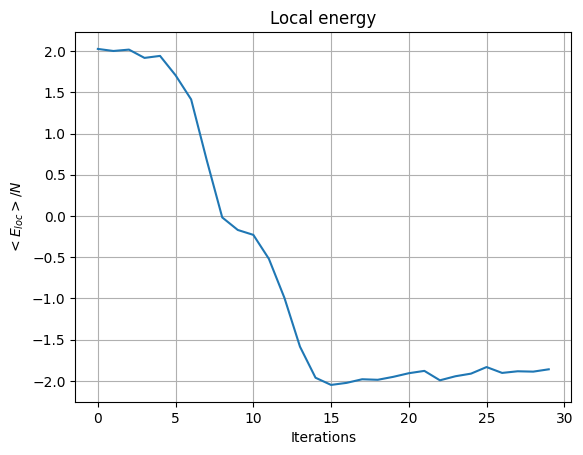

In [ ]:
import matplotlib.pyplot as plt

# 绘制折线图
plt.plot(block_E)
plt.title('Local energy')
plt.grid(True)
plt.ylabel(r'$<E_{loc}>/N$')
plt.xlabel('Iterations')
plt.show()